# Installing and importing libraries

In [1]:
!pip install einops
!pip install scipy==1.11.1
!pip install pytorch_fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 40.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.3.1 which is incompatible.
kaggle-environments 1.14.3 requires scipy>=1.11.2, but you have scipy 1.11.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is 

In [2]:
import torch
import logging
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter
import glob
from inspect import isfunction

2024-03-28 16:13:09.403158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 16:13:09.403291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 16:13:09.499386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import math
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import nn
from torch.nn import Parameter

import functools

from functools import partial
import numpy as np

import os.path

# Defining the required blocks for UNet

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
    
    
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
    
    
class Rezero(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        self.g = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.fn(x) * self.g
    
    
    
    
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        if groups == 0:
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim_out, 3),
                Mish()
            )
        else:
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim_out, 3),
                nn.GroupNorm(groups, dim_out),
                Mish()
            )

    def forward(self, x):
        return self.block(x)


    
    
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))
    
    

In [5]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=0, groups=8):
        super().__init__()
        if time_emb_dim > 0:
            self.mlp = nn.Sequential(
                Mish(),
                nn.Linear(time_emb_dim, dim_out)
            )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)
        if time_emb is not None:
            h += self.mlp(time_emb)[:, :, None, None]
        
        h = self.block2(h)
        return h + self.res_conv(x)

    
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads=self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)
    
    

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
        )

    def forward(self, x):
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 2),
        )

    def forward(self, x):
        return self.conv(x)

### Helper function to generate noise schedule

In [6]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, a_min=0, a_max=0.999)

#### Additional helper functions

In [7]:
def make_layer(block, n_layers, seq=False):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    if seq:
        return nn.Sequential(*layers)
    else:
        return nn.ModuleList(layers)
    
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

## Defining the UNet class which acts as the noise predictor

In [8]:
class Unet(nn.Module):
    def __init__(self, args, dim, out_dim=None, dim_mults=(1, 2, 4, 8)):
        super().__init__()
        dims = [1, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        print(in_out)
        groups = 0
        self.args = args
        

        self.time_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim)
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim=dim, groups=groups),
                ResnetBlock(dim_out, dim_out, time_emb_dim=dim, groups=groups),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim, groups=groups)
        if args.use_attn:
            self.mid_attn = Residual(Rezero(LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim, groups=groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=dim, groups=groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim=dim, groups=groups),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        self.final_conv = nn.Sequential(
            Block(dim, dim, groups=groups),
            nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        t = self.time_pos_emb(time)
        t = self.mlp(t)

        h = []
        
        for i, (resnet, resnet2, downsample) in enumerate(self.downs):
            x = resnet(x, t)
            x = resnet2(x, t)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        if self.args.use_attn:
            x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet, resnet2, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, t)
            x = resnet2(x, t)
            x = upsample(x)

        return self.final_conv(x)

#### Helper functions to extract certain indexes from a tensor and reshaping it to the required shape and a function to generate random noise

In [9]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

## Defining the Diffusion class

* **q_mean_variance** calculates and returns the mean and variance of the forward process distribution

* **predict_start_noise** calculates x_0 which we later plug in to calculate x_t-1

* **q_posterior** calculates and returns the estimated mean and variance of the posterior distribution p(x_t-1|x_t)

* **forward** defines a single training step where we calculate loss between the estimated noise at the given timestep (estimated by our UNet) and the actual amount of noise in the image

* **p_losses** defines different types of losses on which to train the UNet on

* **sample** function samples an image from the calculated posterior distribution over a set of timesteps

* **res2img** is simply used for clipping the output of our model at every timestep so the pixel values don't explode

In [10]:
class GaussianDiffusion(nn.Module):
    def __init__(self, args, denoise_fn, timesteps=1000, loss_type='l1'):
        super().__init__()
        self.denoise_fn = denoise_fn
        
        
        self.args = args
        if args.beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps, s=args.beta_s)
        if args.beta_schedule == 'linear':
            betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
            if args.res:
                betas[-1] = 0.999

        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))
        self.sample_tqdm = True

        
        
    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1. - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    
    
    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    
    
    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    
    
    def p_mean_variance(self, x, t, noise_pred, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(x, t=t, noise=noise_pred)

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance, x_recon

    
    
    def forward(self, x, t=None, *args, **kwargs):
        
        b, *_, device = *x.shape, x.device
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long() \
            if t is None else torch.LongTensor([t]).repeat(b).to(device)
        
        
        p_losses, x_tp1, noise_pred, x_t, x_t_gt, x_0 = self.p_losses(x, t, *args, **kwargs)
        ret = {'q': p_losses}
        
#         x_recon = self.res2img(x_recon)
        x_tp1 = self.res2img(x_tp1)
        x_t = self.res2img(x_t)
        x_t_gt = self.res2img(x_t_gt)
        return ret, (x_tp1, x_t_gt, x_t), t

    
    
    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_tp1_gt = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_t_gt = self.q_sample(x_start=x_start, t=t - 1, noise=noise)
        noise_pred = self.denoise_fn(x_tp1_gt, t)
        x_t_pred, x0_pred = self.p_sample(x_tp1_gt, t, noise_pred=noise_pred)

        if self.loss_type == 'l1':
            loss = (noise - noise_pred).abs().mean()
        elif self.loss_type == 'l2':
            loss = F.mse_loss(noise, noise_pred)
        else:
            raise NotImplementedError()
        return loss, x_tp1_gt, noise_pred, x_t_pred, x_t_gt, x0_pred

    
    
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        t_cond = (t[:, None, None, None] >= 0).float()
        t = t.clamp_min(0)
        return (
                       extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                       extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
               ) * t_cond + x_start * (1 - t_cond)

    
    
    @torch.no_grad()
    def p_sample(self, x, t, noise_pred=None, clip_denoised=True, repeat_noise=False):
        if noise_pred is None:
            noise_pred = self.denoise_fn(x, t)
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance, x0_pred = self.p_mean_variance(
            x=x, t=t, noise_pred=noise_pred, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0_pred

    
    
    @torch.no_grad()
    def sample(self, shape, save_intermediate=False):
        device = self.betas.device
        b = shape[0]
        img = torch.randn(shape, device=device)
        
        it = reversed(range(0, self.num_timesteps))
        if self.sample_tqdm:
            it = tqdm(it, desc='sampling loop time step', total=self.num_timesteps)
        images = []
        for i in it:
            img, x_recon = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long))
            if save_intermediate:
                img_ = self.res2img(img)
                x_recon_ = self.res2img(x_recon)
                images.append((img_.cpu(), x_recon_.cpu()))
        img = self.res2img(img)
        if save_intermediate:
            return img, images
        else:
            return img

    

    def res2img(self, img_, clip_input=None):
        if clip_input is None:
            clip_input = self.args.clip_input
        if self.args.res:
            if clip_input:
                img_ = img_.clamp(-1, 1)
            img_ = img_ 
        return img_


## Defining Dataset class and helper functions to create the dataset, setup logging and save images

In [11]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)  

    data = []
    for img_path in tqdm(root_list):
        data.append(img_path)
        
    return data

class CustomDataset():
    def __init__(self, img_paths_and_labels_list, transform = None):
        self.data = img_paths_and_labels_list

        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
#         print(img_path)
        img = np.load(img_path, allow_pickle=True)
        img = img.squeeze()
        
        
        if self.transform:
            img = self.transform(img)
            
        
        img = img.to(torch.float)
        
        return img

def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)
    
    
import torchvision.transforms.functional as TF
import torch.nn.functional as F

def save_images(images, path, **kwargs):
    # Resize each image before making the grid
    resized_images = [TF.resize(image, (image.size(1)*5, image.size(2)*5)) for image in images]
    # Create the grid
    grid = torchvision.utils.make_grid(resized_images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    ndarr = (ndarr + 1) * 127.5
    ndarr = ndarr.astype(np.uint8)
    im = Image.fromarray(ndarr)
    im.save(path)
    return im

## Defining the training loop

In [21]:
# torch.save(k, '/kaggle/working/stacked_images.pt')

In [12]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.nn import DataParallel

def train(args):
    setup_logging(args.run_name)
    device = args.device
    
    dim_mults = args.unet_dim_mults
    dim_mults = [int(x) for x in dim_mults.split('|')]
    
    denoise_fn = Unet(args,
        args.hidden_size, out_dim=1, dim_mults=dim_mults)
    
    model = GaussianDiffusion(args=args,
            denoise_fn=denoise_fn,
            timesteps=args.timesteps,
            loss_type=args.loss_type
        )
    
#     model = DataParallel(model)
#     checkpoint_path = "/kaggle/working/models/DDPM/ckpt.pt"
#     model.load_state_dict(torch.load(checkpoint_path))

    model = model.to(device)
    
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(144),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
    
    data_root_dir = args.dataset_path
    dataset_img_paths_list = img_paths_list(data_root_dir)
    train_set_image_paths_list=dataset_img_paths_list

    train_dataset = CustomDataset(train_set_image_paths_list, transform = transforms)
    train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle = True)
    
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(train_loader)
    
    count = 0
    min_loss = 2
    for epoch in range(args.epochs):
        print(count)
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(train_loader)
        for i, (images) in enumerate(pbar):
            
            images = images.to(device)

            loss, _, _ = model(images)
            total_loss = sum(loss.values())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            pbar.set_postfix(l1=total_loss.item())
            logger.add_scalar(f"{args.loss_type}", total_loss.item(), global_step=epoch * l + i)
            
        
        
        if count%5==0:
            torch.save(model.state_dict(), os.path.join("/kaggle/working/models", args.run_name, f"ckpt.pt"))
            sampled_images = model.sample(images.shape)
            print(sampled_images.shape)
            ik=save_images(sampled_images, os.path.join("/kaggle/working/results", args.run_name, f"{epoch}.jpg"))
            plt.imshow(ik)
            plt.show(block=False)
            plt.pause(0.5)
            
        count+=1
        if total_loss.item()<min_loss:
            print('saving model as loss decreased!!', epoch)
            torch.save(model.state_dict(), os.path.join("/kaggle/working/models", args.run_name, f"ckpt-loss-min.pt"))
            
        min_loss = min(total_loss.item(), min_loss)

## Defining the validation function

In [13]:
from tqdm import tqdm
def validate(args):
    device = args.device
    
    
    dim_mults = args.unet_dim_mults
    dim_mults = [int(x) for x in dim_mults.split('|')]

    denoise_fn = Unet(args,
            args.hidden_size, out_dim=1, dim_mults=dim_mults)

    model = GaussianDiffusion(args=args,
            denoise_fn=denoise_fn,
            timesteps=args.timesteps,
            loss_type=args.loss_type
        )

    #     model = DataParallel(model)
    checkpoint_path = args.model_checkpoint_path
    model.load_state_dict(torch.load(checkpoint_path))

    model = model.to(device)

    
    

    
    x = torch.randn((16,1,144,144), device = args.device)
    sampled_images = model.sample(x.shape)
#     print(sampled_images.shape)
    ik=save_images(sampled_images, os.path.join("/kaggle/working/", f"{1}.jpg"))
    
    plt.imshow(ik)
    plt.show(block=False)
    plt.pause(0.5)
    return sampled_images

## **All the required parameters are passed below**

In [14]:
def begin():
    import argparse
    parser = argparse.ArgumentParser()
#     parser.add_argument('-f')
    args, unknown = parser.parse_known_args()
    args.timesteps = 1000
    args.loss_type = 'l1'
    args.unet_dim_mults = '1|2|2|4'
    args.res_rescale = 2
    args.clip_input = True
    args.res = True
    args.beta_s=0.008
    args.use_attn = True
    args.beta_schedule = 'cosine'
    args.run_name = "DDPM"
    args.epochs = 100
    args.batch_size = 16
    args.model_checkpoint_path = "/kaggle/input/diff-lenses/pytorch/2/1/ckpt (16).pt"
    args.dataset_path = "/kaggle/input/lenses/*/*"
    args.device = torch.device("cuda")
    
    args.lr = 3e-4
    args.hidden_size = 16
    train(args)
    validate(args)
    
#     final_generated_images = []


#     for i in range(62):
#         sampled_images = validate(args)
#         final_generated_images.append(sampled_images)

#     stacked_images = torch.stack(final_generated_images, dim=0)
#     return stacked_images

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.86it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


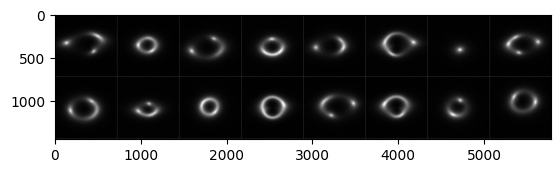

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


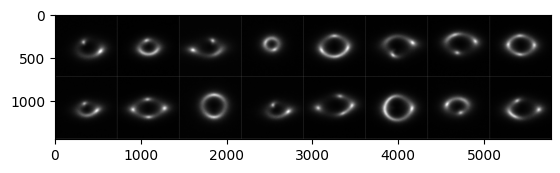

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


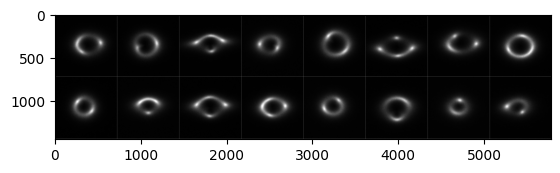

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


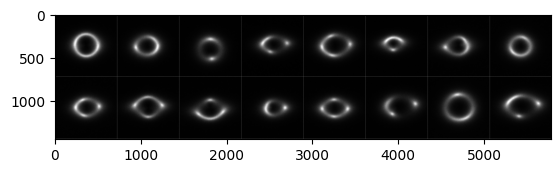

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


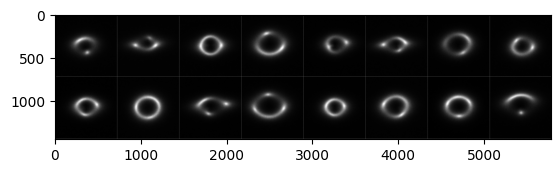

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


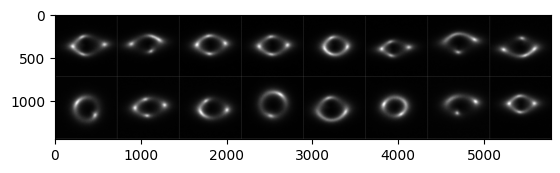

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


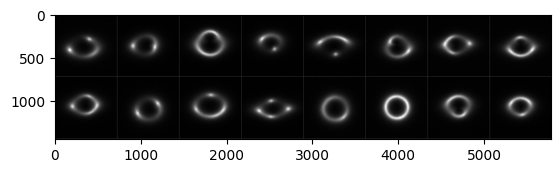

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


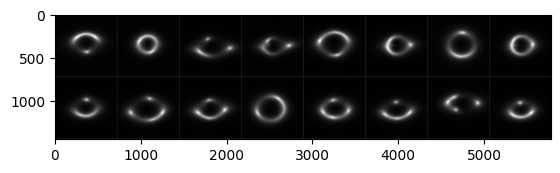

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


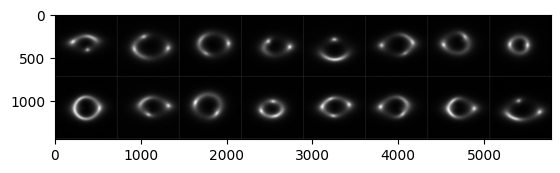

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


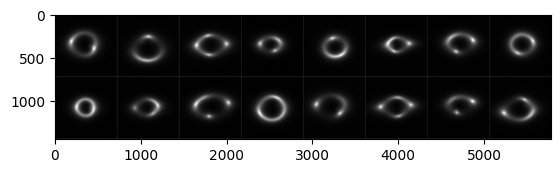

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


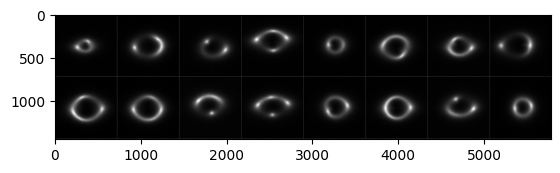

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


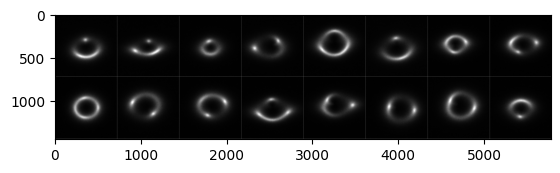

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


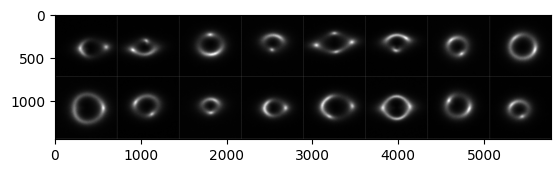

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


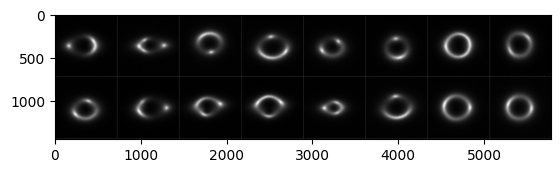

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


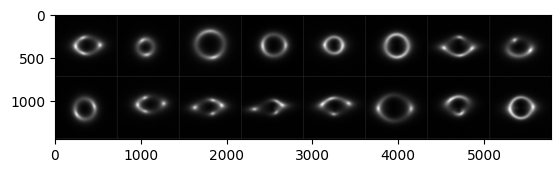

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


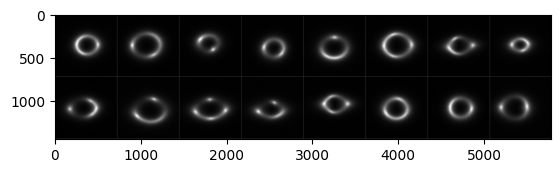

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


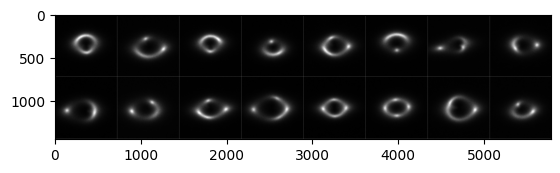

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


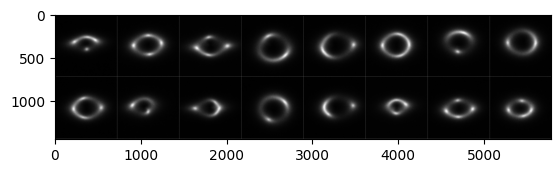

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


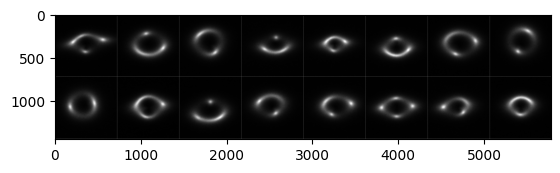

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


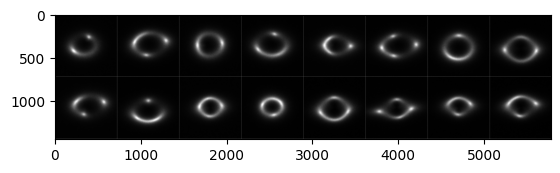

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


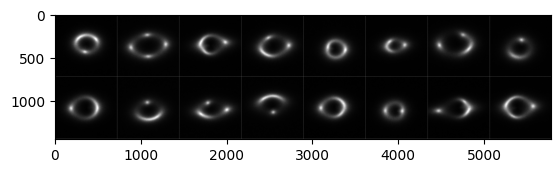

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


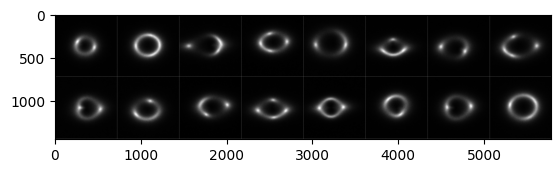

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step:  87%|████████▋ | 873/1000 [00:13<00:01, 63.77it/s]

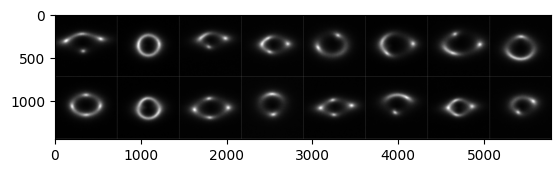

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


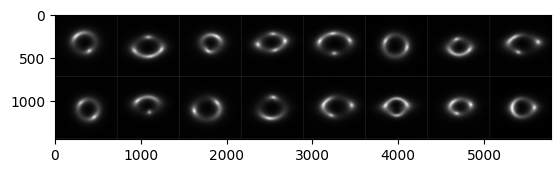

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


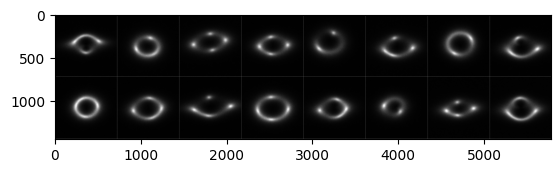

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


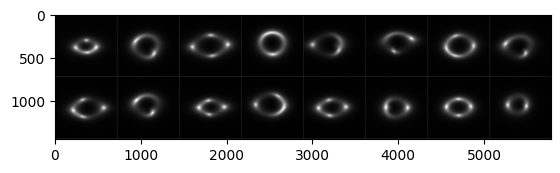

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


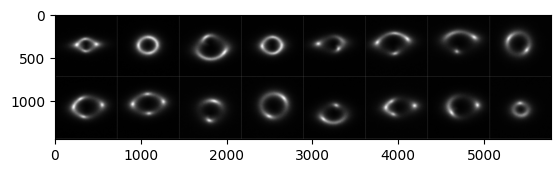

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


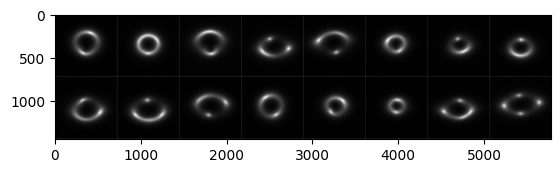

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


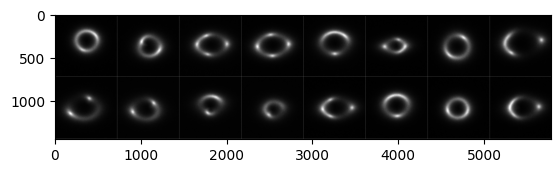

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


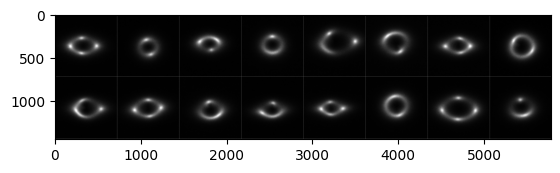

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


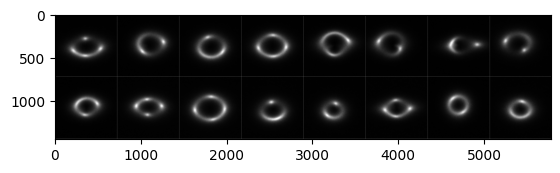

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


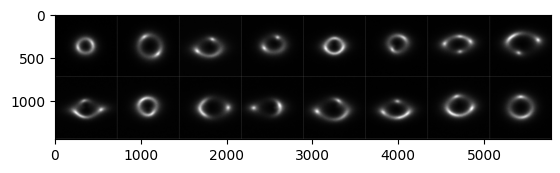

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


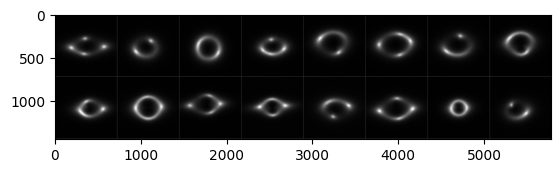

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


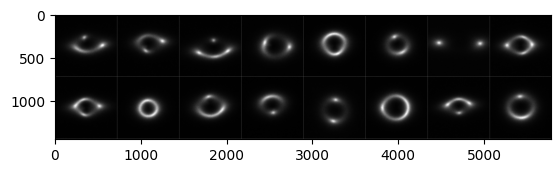

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


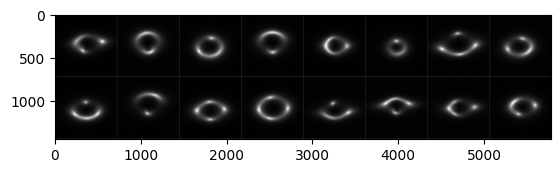

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


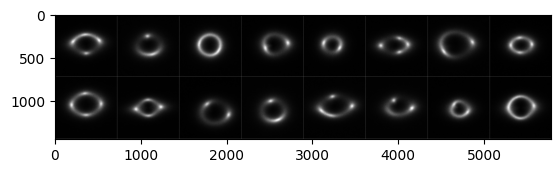

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


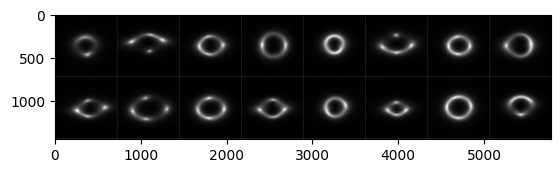

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


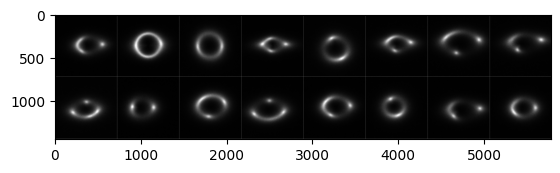

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


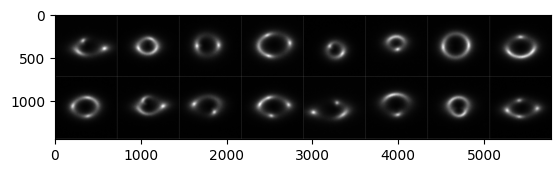

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


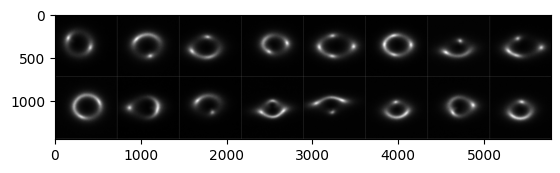

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


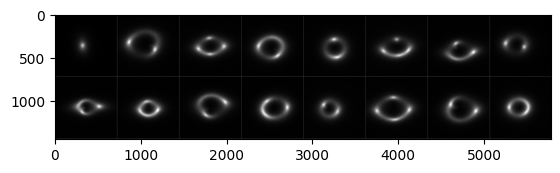

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


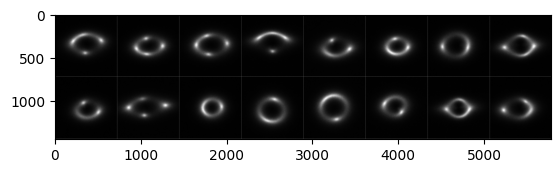

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


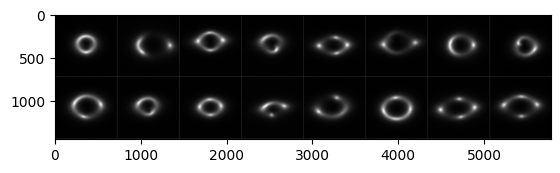

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.90it/s]


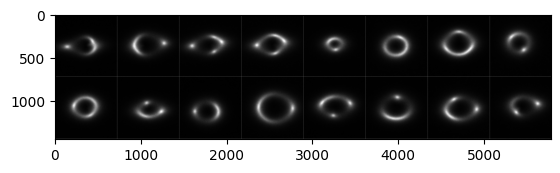

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


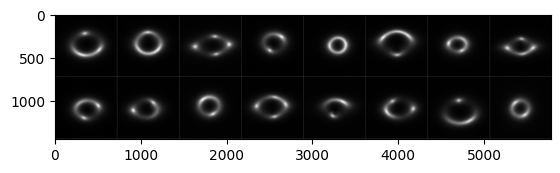

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


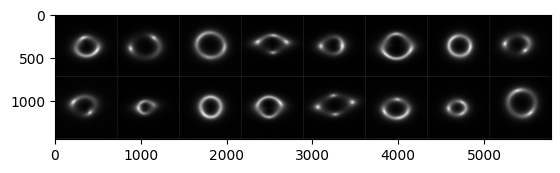

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


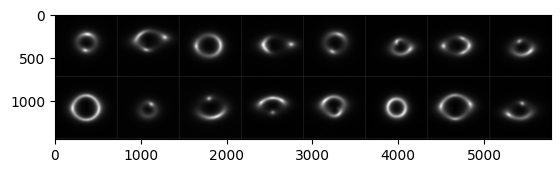

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


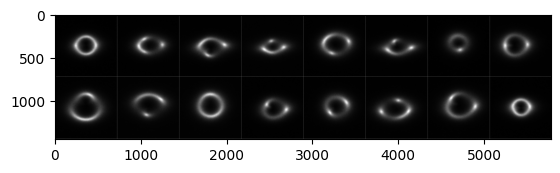

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


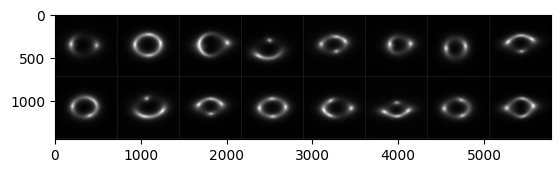

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


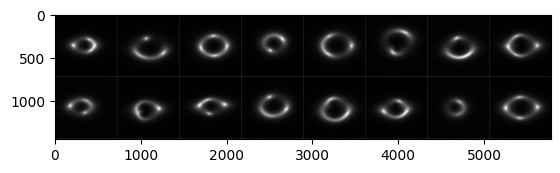

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


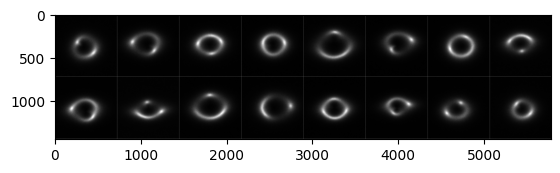

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


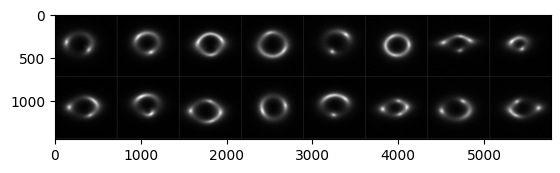

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


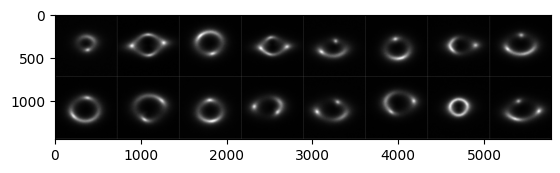

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


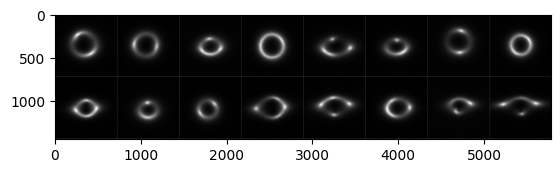

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


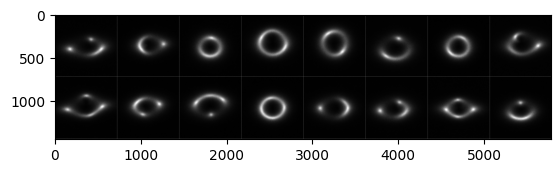

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


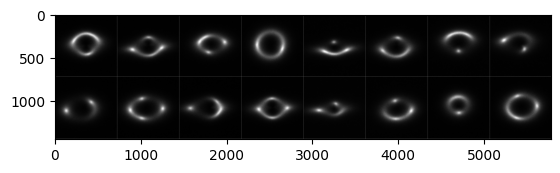

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


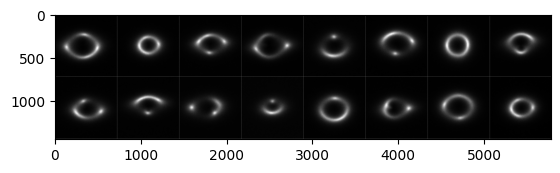

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


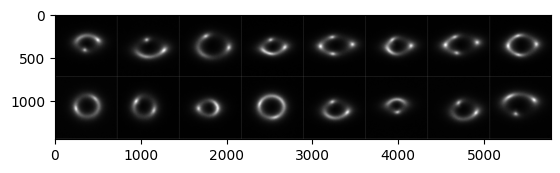

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


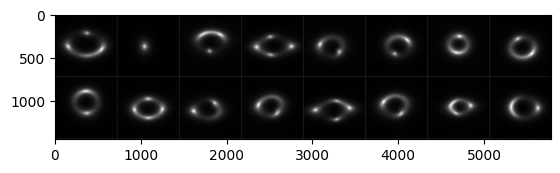

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


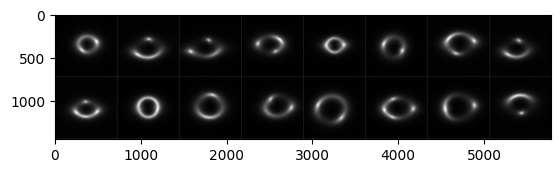

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


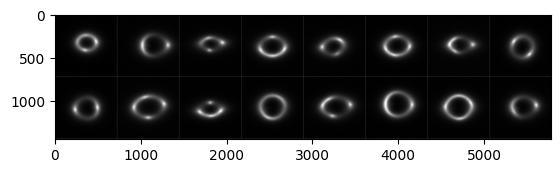

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


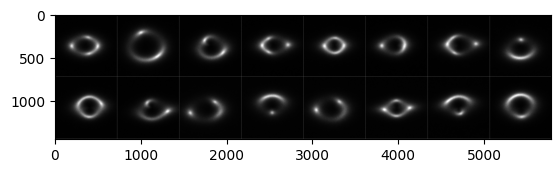

[(1, 16), (16, 32), (32, 32), (32, 64)]


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


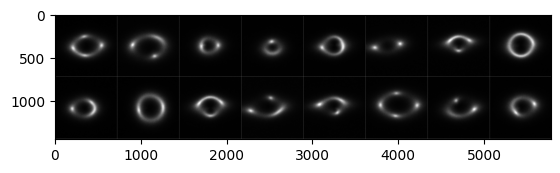

In [19]:
if __name__ == '__main__':
    begin()
    

## Loading generated image tensor and randomly sampled images from the dataset to calculate FID

In [ ]:
final_generated_images = torch.load('/kaggle/input/stacked/final_gen.pt')

In [17]:
final_gt_images = torch.load('/kaggle/input/stacked/final_gt.pt')

### Code to convert tensor to image files and store them in a directory

In [18]:
import os
import numpy as np
from PIL import Image


tensor1 = final_gt_images.numpy()
tensor2 = final_generated_images.numpy()
# Create directories if they don't exist
output_dir1 = "/kaggle/working/gt"
output_dir2 = "/kaggle/working/generated"
os.makedirs(output_dir1, exist_ok=True)
os.makedirs(output_dir2, exist_ok=True)

# Convert and save tensor1 images
for i in range(tensor1.shape[0]):
    img_array = (tensor1[i, 0] * 255).astype(np.uint8)  
    img = Image.fromarray(img_array)
    img.save(os.path.join(output_dir1, f"image_{i}.png"))

# Convert and save tensor2 images
for i in range(tensor2.shape[0]):
    img_array = (tensor2[i, 0] * 255).astype(np.uint8)  
    img = Image.fromarray(img_array)
    img.save(os.path.join(output_dir2, f"image_{i}.png"))

# Calculating FID score

In [20]:
from cleanfid import fid
score = fid.compute_fid("/kaggle/working/gt/", "/kaggle/working/generated/")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


compute FID between two folders
Found 3040 images in the folder /kaggle/working/gt/


FID  : 100%|██████████| 95/95 [00:21<00:00,  4.41it/s]


Found 3040 images in the folder /kaggle/working/generated/


FID  : 100%|██████████| 95/95 [00:10<00:00,  9.38it/s]


In [22]:
print('Final FID score evaluated on 3040 images:', score)

Final FID score evaluated on 3040 images: 6.011121595851975


In [23]:
# final_generated_images = torch.load(r'/kaggle/input/tensor-stack/final_generated_images.pt')
# final_gt_images = torch.load(r'/kaggle/input/tensor-stack/final_gt_images.pt')

In [23]:
# from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# data_root_dir = r'/kaggle/input/lenses/*/*'
# dataset_img_paths_list = img_paths_list(data_root_dir)
# train_set_image_paths_list=dataset_img_paths_list
# transforms = torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Resize(144),
#         torchvision.transforms.Normalize((0.5,), (0.5,))
#     ])
# train_dataset = CustomDataset(train_set_image_paths_list, transform = transforms)
# # train_loader = DataLoader(train_dataset, batch_size = 2048, shuffle = True)

# batch_size = 2048
# num_workers = 0  # Adjust the number of workers as needed
# sampler = SubsetRandomSampler(torch.randint(0, len(train_dataset), (batch_size,)))  # Randomly select indices for the batch
# dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)

100%|██████████| 10000/10000 [00:00<00:00, 1757291.77it/s]


In [77]:
# final_gt_images = final_gt_images/255

In [24]:
# final_generated_images = (final_generated_images+1)/2
# final_gt_images = (final_gt_images+1)/2